In [0]:
import keras
from keras.models import Sequential, Model, save_model, load_model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Softmax
from keras.optimizers import Adam
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import os

# GAN Class

In [0]:
class GAN():
  """
  Description:
    We create a class to build and train a GAN network 
    using mnist handwriting datasets.
    The class implemented a multiple-categorical GAN network 
    by creating a discriminator and several generators.
   
  Usage:
    gan = GAN(class_nums)
    gan.train(epochs=3001, batch_size=64, save_interval=1500) 
    
  Outputs:
    + multigenerator
      1 discriminator model
      N generator models, here N=10
  """
  def __init__(self, class_nums=None):
    """
    Description:
      Class' Constructor
    
    Inputs:
      class_nums: how many categories the generators having to learn to generate
    """
    self.img_rows = 28
    self.img_cols = 28
    self.img_channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
    
    self.class_nums = int(class_nums)
    
    optimizer = Adam(2e-4, 0.5)
    
    # build one discriminator
    # this discriminator is built to classify all categories
    # by default, we use categorical_crossentropy as the loss function
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    # build several generators
    # creating how many generators dependent on how many categories
    # by default, we use categorical_crossentropy as the loss function
    if class_nums is None:
      raise Exception("Class_Nums must be >= 1")
    self.generator = []
    for i in range(self.class_nums):
      class_model = self.build_generator()
      class_model.compile(loss="categorical_crossentropy", optimizer=optimizer)
      self.generator.append(class_model)
    
    # prepare inputs for combined model
    # z (Input) is like a seed being a basement for creating the image
    z = Input(shape=(100,))
    img_class = []
    for i in range(self.class_nums):
      img_class.append(self.generator[i](z))

    # in the combined network we are going to train the generator model
    # so we have to keep the discriminator constant
    # making the gradient clear for the generator
    self.discriminator.trainable = False
    
    # discriminate different categorical images generated by different generators
    # i.e. valid_list[0] is to discriminate images generated from the first class (number 0)
    valid_list = []
    for i in range(self.class_nums):
      valid_list.append(self.discriminator(img_class[i]))
    
    self.combined = []
    for i in range(self.class_nums): 
      com_model = Model(inputs=z, outputs=valid_list[i])
      com_model.compile(loss="categorical_crossentropy", optimizer=optimizer)
      self.combined.append(com_model)
    
  def build_discriminator(self):
    """
    description: discriminate one image
    """
    img_shape = (self.img_rows, self.img_cols, self.img_channels)
    
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(10, activation='softmax'))  # recognize 0~9
    #model.summary()
    
    img = Input(shape=img_shape)
    validity = model(img)
    
    return Model(inputs=img, outputs=validity)
  
  def build_generator(self):
    """
    description: build a generator for two categories
    """
    noise_shape = (100,)
    
    model = Sequential()
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation="tanh"))
    model.add(Reshape(self.img_shape))
    #model.summary()
    
    noise = Input(shape=noise_shape)
    img = model(noise)
    
    return Model(inputs=noise, outputs=img)
  
  def train(self, epochs, batch_size=128, save_interval=100):
    # load dataset
    (x_train, x_label), (_, _) = mnist.load_data()
    
    x_label_data = []
    for i in range(self.class_nums):
      x_label_data.append(np.squeeze(np.where(x_label == i), axis=(0,)))
      
    x_label = keras.utils.to_categorical(x_label, 10)
    
    # normalization
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=3)
    
    # half batch: half is actual, half is fake
    half_batch = batch_size // 2
    
    for epoch in range(epochs):
      
      for i in range(self.class_nums):
        
        # ===================
        # train discriminator
        # ===================        
        batch_x_idx = np.random.randint(0, high=len(x_label_data[i]), size=half_batch)
        batch_x_true_idx = x_label_data[i][batch_x_idx]
        batch_x_train = x_train[batch_x_true_idx]
        batch_x_label = x_label[batch_x_true_idx]
      
        noise = np.random.normal(0, 1, size=(half_batch, 100))
        gen_imgs = self.generator[i].predict(noise)
        
        # here we set up fake labels for training the discriminator
        # due to calculating the loss value and for gradient-based learning, 
        # the fake label is not suitable setting to zero
        #gen_label = np.full((half_batch, 10), 0.1, dtype=np.float32)
        gen_label = np.random.normal(0, 1, size=(half_batch, 10))
        gen_label = keras.utils.to_categorical(np.argmax(gen_label, 1), 10)

        d_loss_real = self.discriminator.train_on_batch(batch_x_train, batch_x_label)
        d_loss_fake = self.discriminator.train_on_batch(gen_imgs, gen_label)
        d_ttl_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ===============
        # train generator
        # ===============
        noise = np.random.normal(0, 1, size=(batch_size, 100))
        
        # try to cheat the discriminator
        fake_y_for_valid = np.zeros((batch_size, 10), dtype=np.float32)
        fake_y_for_valid[:,i] = 1.

        g_loss = self.combined[i].train_on_batch(noise, fake_y_for_valid)
      
        if epoch % save_interval == 0:
          print("{} [class: {}] [D loss: {}, acc: {}%] [G loss: {}]".format(
              epoch, i, d_ttl_loss[0], 100*d_ttl_loss[1], g_loss))
          
      if epoch % save_interval == 0:
        self.plot_imgs(epoch)
        self.save_all_model(epoch)
  
  def plot_imgs(self, epoch):
    r, c = 2, 5
    
    # generate the new noise to make the generator creating images
    noise = np.random.normal(0, 1, (1, 100))
    gen_imgs = []
    for i in range(self.class_nums):
      pred_imgs = self.generator[i].predict(noise)
      pred_imgs = 0.5 * pred_imgs + 0.5  # re-nomralization
      gen_imgs.append(pred_imgs)
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt][0,:,:,0], cmap="gray")
        axs[i,j].axis("off")
        cnt += 1
    plt.show()
    
  def save_all_model(self, epoch):
    model_path = os.path.join(".","GAN_MultiGenerator")
    if not os.path.exists(model_path):
      os.mkdir(model_path)
    
    epoch_model_path = os.path.join(".","GAN_MultiGenerator","epoch-{}".format(epoch))
    if not os.path.exists(epoch_model_path):
      os.mkdir(epoch_model_path)
    
    # save discriminator
    # set to True: avoid [UserWarning: Error in loading the saved optimizer state.]
    save_model(self.discriminator, 
               os.path.join(epoch_model_path,"discriminator-{}.h5".format(epoch)), 
               include_optimizer=False)
    
    # save generator
    for i in range(self.class_nums):
      save_model(self.generator[i], 
                 os.path.join(epoch_model_path,"generator-c{}-{}.h5".format(i,epoch)))

# Training

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [class: 0] [D loss: 2.4063477516174316, acc: 6.25%] [G loss: 2.1285109519958496]
0 [class: 1] [D loss: 3.625825881958008, acc: 4.6875%] [G loss: 2.756683349609375]
0 [class: 2] [D loss: 3.278324604034424, acc: 1.5625%] [G loss: 2.459550142288208]
0 [class: 3] [D loss: 3.0551600456237793, acc: 6.25%] [G loss: 2.3113622665405273]
0 [class: 4] [D loss: 2.7748193740844727, acc: 4.6875%] [G loss: 2.1784257888793945]
0 [class: 5] [D loss: 2.9601402282714844, acc: 4.6875%] [G loss: 2.0697176456451416]
0 [class: 6] [D loss: 2.8429884910583496, acc: 4.6875%] [G loss: 2.295330286026001]
0 [class: 7] [D loss: 3.3152406215667725, acc: 1.5625%] [G loss: 2.7607107162475586]
0 [class: 8] [D loss: 3.0435707569122314, acc: 4.6875%] [G loss: 2.5718374252319336]
0 [class: 9] [D loss: 2.9871814250946045, acc: 3.125%] [G loss: 2.4601354598999023]


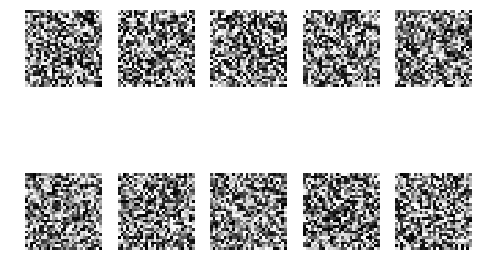

1500 [class: 0] [D loss: 1.7878358364105225, acc: 54.6875%] [G loss: 0.6545320749282837]
1500 [class: 1] [D loss: 1.831756591796875, acc: 48.4375%] [G loss: 0.6464232206344604]
1500 [class: 2] [D loss: 1.7722108364105225, acc: 53.125%] [G loss: 0.6863436698913574]
1500 [class: 3] [D loss: 1.7122923135757446, acc: 56.25%] [G loss: 0.6837006211280823]
1500 [class: 4] [D loss: 1.8188815116882324, acc: 53.125%] [G loss: 0.7086898684501648]
1500 [class: 5] [D loss: 1.790618896484375, acc: 51.5625%] [G loss: 0.7529104948043823]
1500 [class: 6] [D loss: 1.739357829093933, acc: 54.6875%] [G loss: 0.6496436595916748]
1500 [class: 7] [D loss: 1.681365728378296, acc: 56.25%] [G loss: 0.6332677006721497]
1500 [class: 8] [D loss: 1.7326416969299316, acc: 57.8125%] [G loss: 0.685871958732605]
1500 [class: 9] [D loss: 1.9023338556289673, acc: 50.0%] [G loss: 0.6914017200469971]


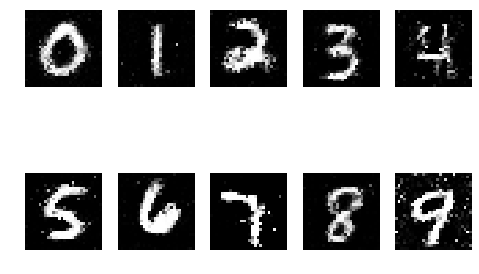

3000 [class: 0] [D loss: 1.7162814140319824, acc: 57.8125%] [G loss: 0.6038814783096313]
3000 [class: 1] [D loss: 1.6795094013214111, acc: 59.375%] [G loss: 0.6700612902641296]
3000 [class: 2] [D loss: 1.7021024227142334, acc: 59.375%] [G loss: 0.6929765939712524]
3000 [class: 3] [D loss: 1.844346523284912, acc: 53.125%] [G loss: 0.6990953683853149]
3000 [class: 4] [D loss: 1.867408037185669, acc: 50.0%] [G loss: 0.7026946544647217]
3000 [class: 5] [D loss: 1.7349504232406616, acc: 56.25%] [G loss: 0.6982055306434631]
3000 [class: 6] [D loss: 1.8363726139068604, acc: 53.125%] [G loss: 0.6449887752532959]
3000 [class: 7] [D loss: 1.7737302780151367, acc: 54.6875%] [G loss: 0.6446441411972046]
3000 [class: 8] [D loss: 1.8254432678222656, acc: 54.6875%] [G loss: 0.6898378133773804]
3000 [class: 9] [D loss: 1.7284152507781982, acc: 56.25%] [G loss: 0.6897563338279724]


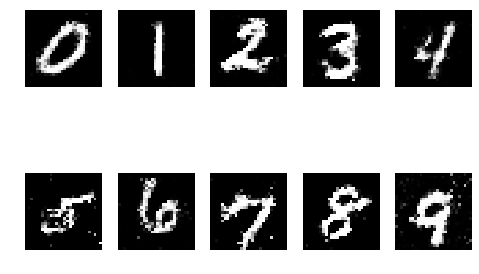

In [40]:
if __name__ == "__main__":
  class_nums = 10
  gan = GAN(class_nums)
  gan.train(epochs=3001, batch_size=64, save_interval=1500)

# Prediction / Inference

In [0]:
epoch = 3000
model_path = os.path.join(".","GAN_MultiGenerator")
epoch_model_path = os.path.join(".","GAN_MultiGenerator","epoch-{}".format(epoch))
assert os.path.exists(model_path), "Model's path was not found."

In [0]:
(_, _), (x_test, y_test) = mnist.load_data()
y_test = keras.utils.to_categorical(y_test, 10)

## Discriminator

Use the discriminator to classify datasets.

In [43]:
dis_model = load_model(os.path.join(epoch_model_path, "discriminator-{}.h5".format(epoch)))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
test_res = dis_model.predict(np.expand_dims(x_test[:10], axis=3))

In [45]:
correct_prediction = np.equal(np.argmax(test_res,1), np.argmax(y_test[:10],1))
accuracy = np.mean(correct_prediction.astype(np.float32))
print("Accuracy: {} %".format(accuracy * 100))

Accuracy: 40.00000059604645 %


In [46]:
print(np.argmax(y_test[:10],1))
print(np.argmax(test_res, 1))

[7 2 1 0 4 1 4 9 5 9]
[7 2 4 0 0 4 6 3 6 9]


## Generator

In [0]:
generator_list = []
class_nums = 10

In [48]:
for i in range(class_nums):
  print("Load model {}".format(i))
  generator_list.append(load_model(os.path.join(epoch_model_path, "generator-c{}-{}.h5".format(i, epoch))))

Load model 0
Load model 1
Load model 2
Load model 3
Load model 4
Load model 5
Load model 6
Load model 7
Load model 8
Load model 9


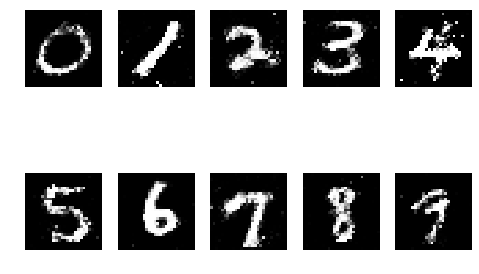

In [49]:
r, c = (2, 5)
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = []
for i in range(class_nums):
  pred_imgs = generator_list[i].predict(noise)
  pred_imgs = 0.5 * pred_imgs + 0.5  # re-nomralization
  gen_imgs.append(pred_imgs)

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
  for j in range(c):
    axs[i,j].imshow(gen_imgs[cnt][0,:,:,0], cmap="gray")
    axs[i,j].axis("off")
    cnt += 1
plt.show()

## Improve data generation

Here we are going to test whether more iterations causing generated data more closely to the real one.

In [0]:
import cv2

Iteration: 1


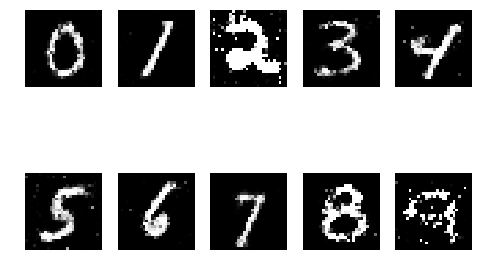

Iteration: 10


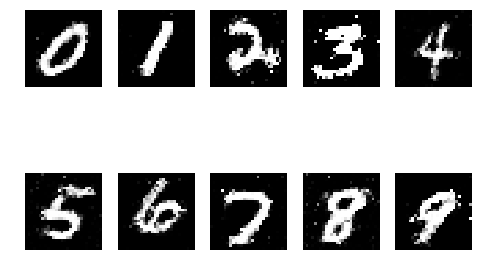

In [51]:
r, c = (2, 5)
noise = np.random.normal(0, 1, (1, 100))
iteration = [1, 10]

# [[1 time], [5 times]]
gen_imgs = []
tmp_imgs_list = []
for k in iteration:
  tmp_imgs_list = []
  for i in range(class_nums):
    for m in range(k):
      if m == 0:
        pred_imgs = generator_list[i].predict(noise)
      else:
        pred_imgs = np.squeeze(pred_imgs, axis=0)
        pred_imgs = cv2.resize(pred_imgs, dsize=(10, 10), interpolation=cv2.INTER_CUBIC)
        pred_imgs = pred_imgs.reshape(1, -1)
        pred_imgs = generator_list[i].predict(pred_imgs)
    pred_imgs = 0.5 * pred_imgs + 0.5  # re-nomralization
    tmp_imgs_list.append(pred_imgs)
  gen_imgs.append(tmp_imgs_list)
  

for k in range(len(iteration)):
  print("=====================")
  print("Iteration: {}".format(iteration[k]))
  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[k][cnt][0,:,:,0], cmap="gray")
      axs[i,j].axis("off")
      cnt += 1
  plt.show()
  print("=====================")

# Download the model

In [52]:
!zip -r GANM.zip ./GAN_MultiGenerator/epoch-6000

updating: GAN_MultiGenerator/epoch-6000/ (stored 0%)
updating: GAN_MultiGenerator/epoch-6000/generator-c4-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c8-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c1-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c2-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c0-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c9-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c5-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/discriminator-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c7-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c6-6000.h5 (deflated 7%)
updating: GAN_MultiGenerator/epoch-6000/generator-c3-6000.h5 (deflated 7%)
